# Basic setting

In [6]:
 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
 
# Device
torch.cuda.set_device(0) # set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# 超参数设置
num_epochs = 2
num_classes = 10
batch_size = 32
learning_rate = 0.01

# Load CIFAR-10 datasets and use Data Augmentation

In [7]:
# cifar10 classification
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
 
# Data Augumentation
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])
 
# CIFAR-10 dataset
training_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, transform=train_transform, download=True)
validation_dataset = torchvision.datasets.CIFAR10(root='./data/', train=False, transform=val_transform)
 
# Data loader
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


# View an image and its corresponding label

cat


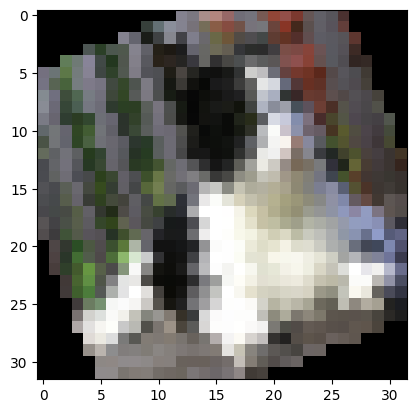

In [12]:
# 查看数据, 取一组batch
data_iter = iter(training_loader)
images, labels = next(data_iter)
 
# 取batch中的一张图像
idx = 15
image = images[idx].numpy()             # image: (3, 32, 32)
image = np.transpose(image, (1, 2, 0))  # image: (32, 32, 3)
plt.imshow(image)
plt.savefig("expamle.png")
print(classes[labels[idx].numpy()])     # ship

# Design the net and train、eval and save the model

In [24]:
model = torchvision.models.vgg19_bn(num_classes=10)
model.to(device)
summary(model, (3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-10                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 16, 16]        

In [25]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# TensorBoard SummaryWriter
writer = SummaryWriter()

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(training_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(training_loader)
    accuracy = 100 * correct / total

    # Record train loss and accuracy to TensorBoard
    writer.add_scalar('Train/Loss', average_loss, epoch)
    writer.add_scalar('Train/Accuracy', accuracy, epoch)
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(validation_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    # Record validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation/Loss', average_val_loss, epoch)
    writer.add_scalar('Validation/Accuracy', val_accuracy, epoch)
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], train loss: {average_loss:.4f}, train acc: {accuracy:.2f}%, '
          f'val loss: {average_val_loss:.4f}, val acc: {val_accuracy:.2f}%')

# Close TensorBoard SummaryWriter
writer.close()

Epoch [1/50], train loss: 2.5938, train acc: 10.58%, val loss: 2.3183, val acc: 9.16%
Epoch [2/50], train loss: 2.4253, train acc: 10.53%, val loss: 2.2806, val acc: 12.62%
Epoch [3/50], train loss: 2.1174, train acc: 17.24%, val loss: 2.2376, val acc: 17.18%
Epoch [4/50], train loss: 1.9985, train acc: 19.47%, val loss: 2.1903, val acc: 21.10%
Epoch [5/50], train loss: 1.9438, train acc: 21.21%, val loss: 1.9337, val acc: 23.49%
Epoch [6/50], train loss: 1.8914, train acc: 24.11%, val loss: 1.8652, val acc: 24.28%
Epoch [7/50], train loss: 1.8404, train acc: 26.63%, val loss: 1.7464, val acc: 30.98%
Epoch [8/50], train loss: 1.7595, train acc: 29.71%, val loss: 1.7470, val acc: 28.79%
Epoch [9/50], train loss: 1.7075, train acc: 32.07%, val loss: 1.6543, val acc: 30.17%
Epoch [10/50], train loss: 1.6175, train acc: 34.94%, val loss: 1.4494, val acc: 40.47%
Epoch [11/50], train loss: 1.5387, train acc: 39.05%, val loss: 1.3734, val acc: 46.47%
Epoch [12/50], train loss: 1.4557, train a

In [26]:
# Save the model
torch.save(model.state_dict(), 'cifar10_vgg19.pth')

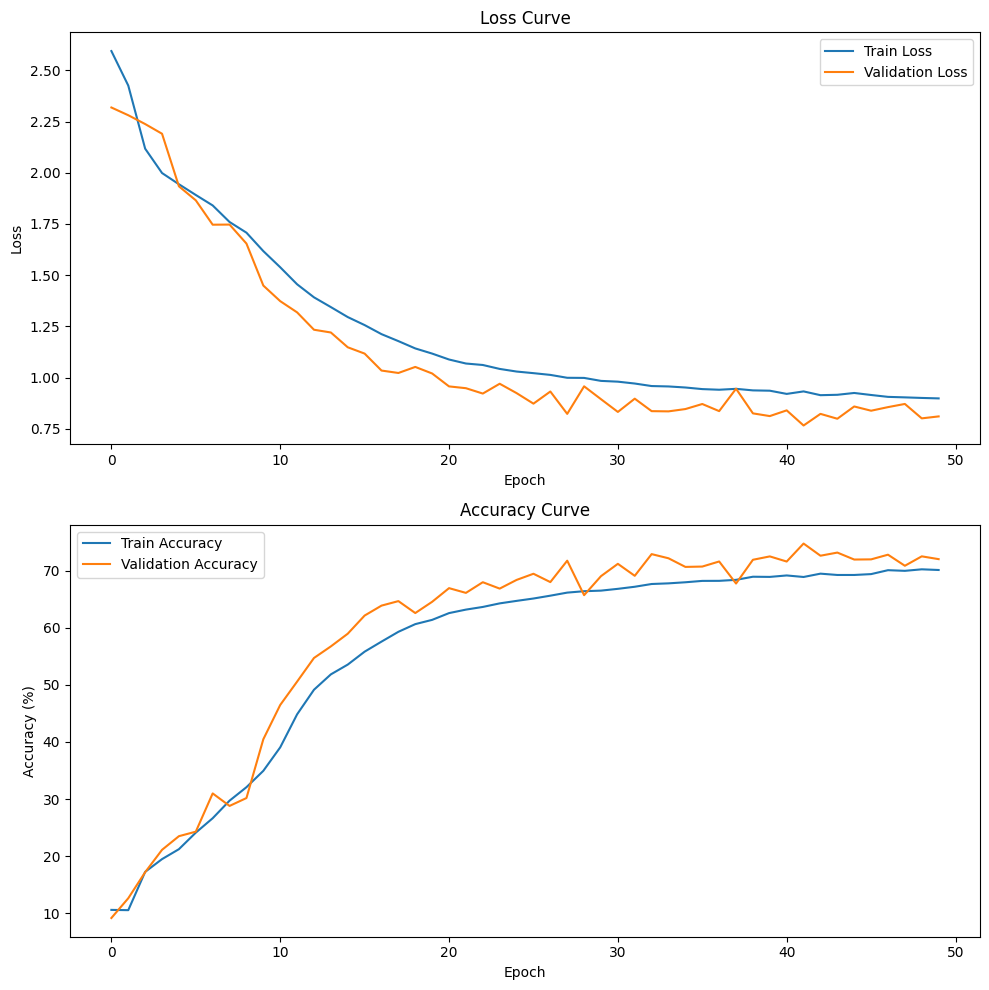

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# First: Loss Curve
axes[0].plot(range(num_epochs), train_losses, label='Train Loss')
axes[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss Curve')

# Second: Accuracy Curve
axes[1].plot(range(num_epochs), train_accuracies, label='Train Accuracy')
axes[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].set_title('Accuracy Curve')

plt.tight_layout()
plt.savefig('loss_accuracy_curves.png')
plt.show()

In [36]:
# 设置为评估模式
model.eval()
# 节省计算资源，不去计算梯度
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
 
 
#  保存模型
torch.save(model.state_dict(), 'model.ckpt')
# 查看数据,取一组batch
data_iter = iter(test_loader)
images, labels = next(data_iter)

Test Accuracy of the model on the test images: 10.0 %


# Testing

## with Testing Set

In [ ]:
# 取测试集图像测试
# 取batch中的一张图像，显示图像和真实标签
idx = 10
image = images[idx].numpy()
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)
plt.savefig("example2.png")
print(classes[labels[idx].numpy()])
 
# 转换为（B,C,H,W）大小
imagebatch = image.reshape(-1, 3, 32, 32)
# 转换为torch tensor
image_tensor = torch.from_numpy(imagebatch)
 
# 调用模型进行评估
model.eval()
output = model(image_tensor.to(device))
_, predicted = torch.max(output.data, 1)
pre = predicted.cpu().numpy()
print(pre)   # 查看预测结果ID
print(classes[pre[0]])

## with Any Image

In [32]:
# Load Weight
test_model = torchvision.models.vgg19_bn(num_classes=10)
test_model.load_state_dict(torch.load('cifar10_vgg19.pth'))
test_model.eval()

<All keys matched successfully>

[9]
truck


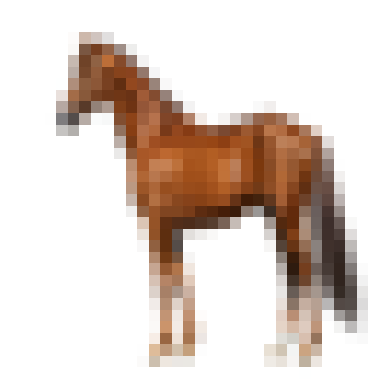

In [42]:
srcPath = 'horse.jpg'
image_temporary = np.array(plt.imread(srcPath))

from PIL import Image
img = np.array(Image.fromarray(image_temporary).resize((32, 32))) # (3, 32, 32)
 
plt.imshow(img) # 显示图片
plt.axis('off')

img_batch = img.reshape(-1, 3, 32, 32)
img_tensor = torch.from_numpy(_).float()

output = model(img_tensor.to(device))
_, predicted = torch.max(output.data, 1)
pre = predicted.cpu().numpy()

print(pre)
print(classes[pre[0]])

tensor([[ -6.3758,   9.0046, -13.1416, -11.2046, -17.9384,  -2.2242,  -1.2940,
         -13.4993,  -9.0121,  14.8974]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


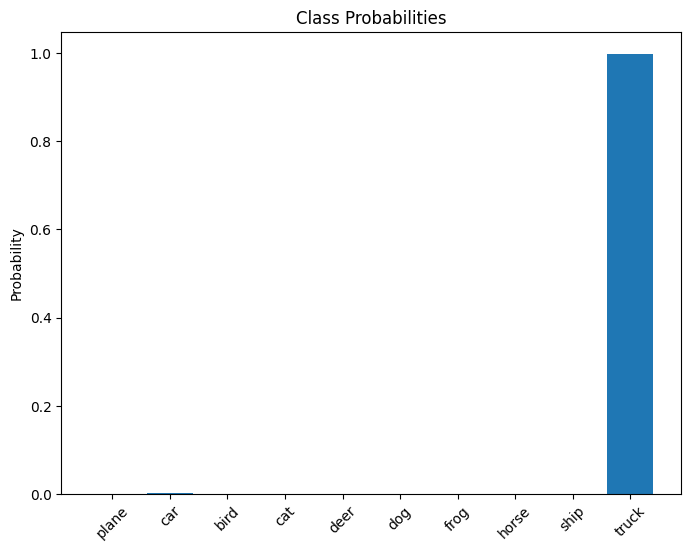

In [41]:
# 使用模型进行推断
output = model(img_tensor.to(device))
print(output)

# 將輸出轉換成機率
probabilities = nn.functional.softmax(output[0], dim=0)
predicted_class = torch.argmax(probabilities).item()

plt.figure(figsize=(8, 6))
plt.bar(classes, probabilities.cpu().detach().numpy())
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.title('Probability of each class')
plt.show()